In [1]:
%%capture
%run naive_algorithm.ipynb
%run features_engineering.ipynb

In [2]:
import random 
import seaborn as sns
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from sklearn.preprocessing import StandardScaler

## Split Train/Test

Probleme de segments dans lequel sont compris d'autres segments , pour eviter de la fuite de données dans le cas ou
segment se retrouverais dans le train et une partie de celui ci dans le train : 

* Calcul de jour calendaire/année de chaque segment
* Selection au hasard de certaines dates qui constitueront le test_set , tout le reste dans le train_set
* De cette maniere aucun segment réalisé a une meme date ne pourra se retrouver a la fois dans le train et le test


In [3]:
segments_df.head(5)

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,maximum_grade,climb_category,average_heart_rate,max_heart_rate,start_time,start_date,nb_activities_last_30d,type_virtualride,time_virtual_last_30d,time_real_last_30d
0,24674235,4831255939,10944546,Champs-Élysées,653,653,6623.10,82.3,202.8,0.0,4.6,0,161.2,170.0,18:46:25,2021-02-22,6,1,213.85,101.4
1,27141377,4831057316,10944546,Epic KOM - Start to Bypass Intersection (Zwift...,424,424,1882.50,77.3,201.2,3.8,47.8,0,157.9,164.0,18:19:40,2021-02-22,6,1,213.85,101.4
2,22501195,4818094466,10944546,Villenave-Technopole,789,789,5100.50,NaN,108.0,0.5,6.4,0,169.0,184.0,14:39:32,2021-02-20,6,0,262.78,0.0
3,3566434,4818094466,10944546,Col du Chateau d'eau,217,217,1190.37,NaN,141.8,2.1,7.3,0,170.7,183.0,14:40:47,2021-02-20,6,0,262.78,0.0
4,20598228,4818094466,10944546,Col du chateau d'eau court,151,151,745.40,NaN,165.4,2.8,5.5,0,177.5,183.0,14:42:02,2021-02-20,6,0,262.78,0.0


In [4]:
calendar_days = []
for date in segments_df['start_date']:
    calendar_day = date.strftime('%j%Y')
    calendar_days.append(calendar_day)

segments_df['calendar_day'] = calendar_days

In [5]:
dates = segments_df['calendar_day'].unique()

In [6]:
dates = dates.tolist()

In [7]:
ratio_train_test = len(dates) * 0.2
ratio_train_test

40.0

In [8]:
random.seed(42)
dates_test_set = random.sample(dates,int(ratio_train_test))

In [9]:
test_set = segments_df[segments_df['calendar_day'].isin(dates_test_set)]
test_set.shape

(379, 21)

In [10]:
test_set_index = test_set.index
test_set_index

Int64Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
            ...
            1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886],
           dtype='int64', length=379)

In [11]:
train_set = segments_df.drop(test_set_index)
train_set

,id,activity_id,athlete_id,name,elapsed_time,moving_time,distance,average_cadence,average_watts,average_grade,...,climb_category,average_heart_rate,max_heart_rate,start_time,start_date,nb_activities_last_30d,type_virtualride,time_virtual_last_30d,time_real_last_30d,calendar_day
0,24674235,4831255939,10944546,Champs-Élysées,653,653,6623.100,82.3,202.8,0.0,...,0,161.2,170.0,18:46:25,2021-02-22,6,1,213.85,101.4,0532021
1,27141377,4831057316,10944546,Epic KOM - Start to Bypass Intersection (Zwift...,424,424,1882.500,77.3,201.2,3.8,...,0,157.9,164.0,18:19:40,2021-02-22,6,1,213.85,101.4,0532021
27,27180136,4801436758,10944546,Kent Rd Climb to Sprint Banner (Zwift Insider ...,176,176,1137.300,81.4,183.4,2.6,...,0,149.4,156.0,13:36:00,2021-02-17,6,1,254.98,0.0,0482021
28,21748007,4801436758,10944546,Yorkshire Sprint Reverse,63,63,394.300,79.9,182.9,2.1,...,0,153.4,156.0,13:37:53,2021-02-17,6,1,254.98,0.0,0482021
29,27207377,4801436758,10944546,Finishing Straightaway (Zwift Insider verified),99,99,611.100,78.4,192.3,3.3,...,0,156.7,162.0,13:40:47,2021-02-17,6,1,254.98,0.0,0482021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1935,17782861,1597380847,10944546,RadarStadeMartillac,40,40,303.400,NaN,189.4,1.4,...,0,176.8,182.0,12:42:52,2018-05-26,0,0,0.00,0.0,1462018
1936,3654728,1597380847,10944546,Faux plat chemin de Rochemorin,90,90,541.374,NaN,158.9,2.0,...,0,183.6,188.0,12:47:30,2018-05-26,0,0,0.00,0.0,1462018
1937,3752963,1597380847,10944546,Imitationberg,141,141,872.000,NaN,82.3,-0.0,...,0,168.2,184.0,12:53:34,2018-05-26,0,0,0.00,0.0,1462018
1938,14775448,1597380847,10944546,Château Vignau - Chemin de Couhins,226,226,1431.800,NaN,84.4,-0.6,...,0,155.2,186.0,12:56:14,2018-05-26,0,0,0.00,0.0,1462018


In [12]:
1561/1940

0.804639175257732

## Model

In [13]:
columns = ['elapsed_time','distance','average_grade','climb_category','nb_activities_last_30d','type_virtualride','time_virtual_last_30d','time_real_last_30d']
corrmat = train_set[columns].corr()
corrmat

,elapsed_time,distance,average_grade,climb_category,nb_activities_last_30d,type_virtualride,time_virtual_last_30d,time_real_last_30d
elapsed_time,1.000000,0.867961,0.179051,0.861286,-0.044467,0.296199,0.011322,-0.163704
distance,0.867961,1.000000,-0.100558,0.582509,0.006663,0.230796,0.055301,-0.143515
average_grade,0.179051,-0.100558,1.000000,0.342676,0.160506,0.534938,0.198791,-0.175962
climb_category,0.861286,0.582509,0.342676,1.000000,-0.073324,0.334232,-0.010541,-0.159363
nb_activities_last_30d,-0.044467,0.006663,0.160506,-0.073324,1.000000,0.310848,0.932515,0.056579
type_virtualride,0.296199,0.230796,0.534938,0.334232,0.310848,1.000000,0.401503,-0.402101
time_virtual_last_30d,0.011322,0.055301,0.198791,-0.010541,0.932515,0.401503,1.000000,-0.216512
time_real_last_30d,-0.163704,-0.143515,-0.175962,-0.159363,0.056579,-0.402101,-0.216512,1.000000


In [14]:
columns = ['elapsed_time','distance','climb_category','type_virtualride','time_virtual_last_30d','time_real_last_30d']
# columns = ['elapsed_time','distance','average_grade']
train_set = train_set[columns]
test_set = test_set[columns]

In [15]:
y_train = train_set["elapsed_time"]
X_train = train_set.drop("elapsed_time", axis=1)
y_test  = test_set["elapsed_time"]
X_test = test_set.drop("elapsed_time", axis=1)


print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1561,)
(1561, 5)
(379,)
(379, 5)


**Log Label**

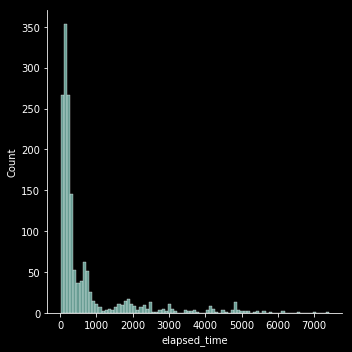

In [16]:
sns.displot(y_train)

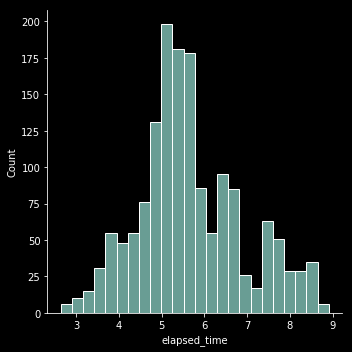

In [17]:
sns.displot(np.log(y_train))

In [18]:
y_train_log = np.log(y_train)

## Scaler ##

In [19]:
# standard_scaler = StandardScaler()

In [20]:
# standard_scaler.fit(X_train)

In [21]:
# X_train_scaled = standard_scaler.transform(X_train)
# X_test_scaled = standard_scaler.transform(X_test)

#### Algos

In [22]:
reg = LinearRegression()
reg.fit(X_train,y_train_log)
y_pred_reg_log = reg.predict(X_test)

In [23]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train,y_train_log)
y_pred_xgb_log = xgb_reg.predict(X_test)

In [24]:
mae_reg = mean_absolute_error(y_test,np.exp(y_pred_reg_log))
mape_reg = mean_absolute_percentage_error(y_test, np.exp(y_pred_reg_log))
rmse_reg  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_reg_log)))
print(f'mae_reg : {mae_reg}')
print(f'mape_reg : {mape_reg}')
print(f'rmse_reg: {rmse_reg}')

mae_reg : 288.6341053290749
mape_reg : 0.8751296286903119
rmse_reg: 735.5823112768717


In [25]:
mae_xgb = mean_absolute_error(y_test,np.exp(y_pred_xgb_log))
mape_xgb = mean_absolute_percentage_error(y_test, np.exp(y_pred_xgb_log))
rmse_xgb  = np.sqrt(mean_squared_error(y_test,np.exp(y_pred_xgb_log)))
print(f'mae_xgb : {mae_xgb}')
print(f'mape_xgb: {mape_xgb}')
print(f'rmse_xgb: {rmse_xgb}')

mae_xgb : 76.03302989849
mape_xgb: 0.19644492954755122
rmse_xgb: 138.48119610213655


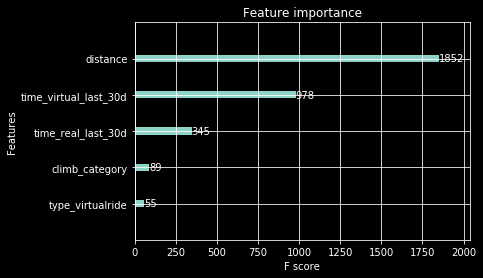

In [26]:
xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

In [ ]:
data = {
    'MAE':[mae_naive,mae_reg,mae_xgb],
    'MAPE':[mape_naive,mape_reg,mape_xgb],
    'RMSE':[rmse_naive,rmse_reg,rmse_xgb]
}

comparaison_df = pd.DataFrame(data, index=['naive','linreg','xgbreg'])
comparaison_df.sort_values(by=['MAPE'])

### 50 biggests Errors Pred XGB

In [ ]:
test_set['pred'] = np.exp(y_pred_xgb_log)
test_set['error_pred'] = abs(test_set['pred'] - test_set['elapsed_time'])
biggest_errors = test_set.sort_values(by=['error_pred'], ascending=False).head(50)

In [ ]:
segments_df.loc[biggest_errors.index]

### Prediction Alpe d'huez

In [27]:
query = {
    "query": {
        "match": {
            "_id": 2787335981548134218
        }
    }
}

result = database.search(
    index="index_route",
    size=1000,
    body= query
)

route_alpe = result['hits']['hits'][0]['_source']
segments_alpe = route_alpe.get("segmentation")
segments_alpe_df = pd.DataFrame(segments_alpe)
segments_alpe_df

,distance,altitude_gain,average_grade,all_points
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000..."
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45...."
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45..."
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000..."


**Time Activities last 30d**

In [28]:
today = date.today()
end_date = today - timedelta(days=1)
start_date = end_date - timedelta(days=30)

In [38]:
activities_last_30d = activities_df[activities_df['start_date'].between(start_date,end_date)]
nb_activities_last_30d = len(activities_last_30d)
time_virtual_last_30d = round((activities_last_30d.loc[activities_last_30d['type'] == 'VirtualRide']['elapsed_time'].sum() / 60),2)
time_real_last_30d = round((activities_last_30d.loc[activities_last_30d['type'] == 'Ride']['elapsed_time'].sum() / 60),2)

In [39]:
# segments_alpe_df['nb_activities_last_30d'] = nb_activities_last_30d
segments_alpe_df['time_virtual_last_30d'] = time_virtual_last_30d
segments_alpe_df['time_real_last_30d'] = time_real_last_30d
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_virtual_last_30d,time_real_last_30d
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",255.7,101.4
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",255.7,101.4
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",255.7,101.4
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",255.7,101.4


**Home Trainer**

In [66]:
segments_alpe_df['type_virtualride'] = 0
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_virtual_last_30d,time_real_last_30d,type_virtualride,climb_category
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",255.7,101.4,0,0
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",255.7,101.4,0,0
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",255.7,101.4,0,0
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",255.7,101.4,0,5


**Climb Category**

In [67]:
climb_category = []
for average_grade, distance in zip(segments_alpe_df['average_grade'],segments_alpe_df['distance']):
    result = average_grade * distance
    if result <= 8000:
        climb_cat = 0
    elif result > 8000 and result <= 16000:
        climb_cat = 4
    elif result > 16000 and result <= 32000:
        climb_cat = 3
    elif result > 32000 and result <= 64000:
        climb_cat = 2
    elif result > 64000 and result <= 80000:
        climb_cat = 1
    elif result > 80000:
        climb_cat = 5
    climb_category.append(climb_cat)
climb_category

[0, 0, 0, 5]

In [68]:
segments_alpe_df['climb_category'] = climb_category
segments_alpe_df

,distance,altitude_gain,average_grade,all_points,time_virtual_last_30d,time_real_last_30d,type_virtualride,climb_category
0,270.55,-0.80,-0.30,"[[45.05476, 6.031770000000001], [45.0547500000...",255.7,101.4,0,0
1,422.22,4.33,1.03,"[[45.056370001328915, 6.034199995890939], [45....",255.7,101.4,0,0
2,427.89,-5.51,-1.29,"[[45.059050000000006, 6.0379000000000005], [45...",255.7,101.4,0,0
3,12615.51,1063.27,8.43,"[[45.062720000000006, 6.03701], [45.0628500000...",255.7,101.4,0,5


**Prediction**

In [69]:
cols_to_predict = ['distance','climb_category','type_virtualride','time_virtual_last_30d','time_real_last_30d']
datas = segments_alpe_df[cols_to_predict]
datas

,distance,climb_category,type_virtualride,time_virtual_last_30d,time_real_last_30d
0,270.55,0,0,255.7,101.4
1,422.22,0,0,255.7,101.4
2,427.89,0,0,255.7,101.4
3,12615.51,5,0,255.7,101.4


In [70]:
alpe_pred_reg = reg.predict(datas)
elapsed_time_reg = relativedelta(seconds=(np.exp(alpe_pred_reg)).sum())
elapsed_time_reg

relativedelta(hours=+1, minutes=+38, seconds=+21.3988)

In [71]:
alpe_pred_xgb = xgb_reg.predict(datas)
elapsed_time_xgb = relativedelta(seconds=(np.exp(alpe_pred_xgb)).sum())
elapsed_time_xgb

relativedelta(hours=+1, minutes=+11, seconds=+32.6553)

In [72]:
elapsed_time_naive

relativedelta(minutes=+38, seconds=+32.1867)

In [73]:
def format_hms_relativedelta(relative_delta):
    hour = int(relative_delta.hours)
    minutes = int(relative_delta.minutes)
    seconds = int(relative_delta.seconds)
    print(f'Prediction {hour}h{minutes}m{seconds}sec')
    return f'{hour}h{minutes}m{seconds}sec'

In [74]:
def compute_kmh(time,distance):
    return (distance/time)*3.6

In [75]:
def compute_pred_seconds(pred):
    return round(np.exp(pred).sum(),2)

In [76]:
distance = segments_alpe_df['distance'].sum()
distance

13736.17

In [77]:
data = {
    'Prediction':[
                  format_hms_relativedelta(elapsed_time_naive),
                  format_hms_relativedelta(elapsed_time_reg),
                  format_hms_relativedelta(elapsed_time_xgb),
                  '0h31m39s'
                 ],
    'Mean_speed(km/h)':[
                        distance / elapsed_time_pred_naive_sec * 3.6,
                        compute_kmh(compute_pred_seconds(alpe_pred_reg),distance),
                        compute_kmh(compute_pred_seconds(alpe_pred_xgb),distance),
                        distance / 1899 * 3.6
                        ]
}

comparaison_pred_df = pd.DataFrame(data, index=['naive','linreg','xgbreg','strava'])
comparaison_pred_df

Prediction 0h38m32sec
Prediction 1h38m21sec
Prediction 1h11m32sec


,Prediction,Mean_speed(km/h)
naive,0h38m32sec,21.386773
linreg,1h38m21sec,8.379404
xgbreg,1h11m32sec,11.519713
strava,0h31m39s,26.040133
